# Predicting Newsletter Subscription Based on Player Behaviour
## Introduction
**Background**: UBC's Pacific Laboratory for Artificial Intelligence (PLAI) research group runs a Minecraft server called PLAICraft to study player behaviour. They want to know what player traits and behaviours are linked to subscribing to a newsletter.

**Research Question**: Can we predict whether a player will subscribe to a newsletter based on their demographics and gameplay behaviour?

In [123]:
# Load libraries
library(tidyverse)
library(tidymodels)
library(lubridate)
library(dplyr)

## Data Loading

In [124]:
# Load data
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Data Wrangling

In [125]:
# Compute session duration
sessions2 <- sessions |>
    mutate(
        start_time = dmy_hm(start_time),
        end_time = dmy_hm(end_time),
        duration_minutes = as.numeric(difftime(end_time, start_time, units = "mins")))

# Summary table for player data
session_summary <- sessions2 |>
    group_by(hashedEmail) |>
    summarize(total_sessions = n(),
             total_minutes_played = sum(duration_minutes, na.rm = TRUE),
             avg_session_duration = mean(duration_minutes, na.rm = TRUE))

# Merge with player data
players_merge <- players |>
    left_join(session_summary, by = "hashedEmail") |>
    mutate(
        total_sessions = replace_na(total_sessions, 0),
        total_minutes_played = replace_na(total_minutes_played, 0),
        avg_session_duration = replace_na(avg_session_duration, 0),
        total_hours_played = total_minutes_played / 60,
        subscribe = as_factor(subscribe)) |>
    drop_na()

## Data Visualization

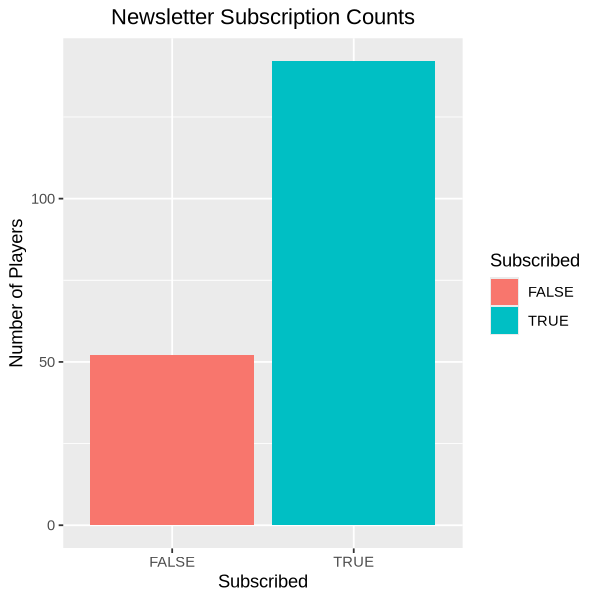

In [126]:
# Newsletter Subscription Counts
options(repr.plot.width = 5, repr.plot.height = 5)
sub_count <- players_merge |>
    ggplot(aes(x = subscribe, fill = subscribe)) +
    geom_bar() +
    labs(x = "Subscribed", y = "Number of Players", title = "Newsletter Subscription Counts", fill = "Subscribed") +
    theme(plot.title = element_text(hjust = 0.5))
    
sub_count

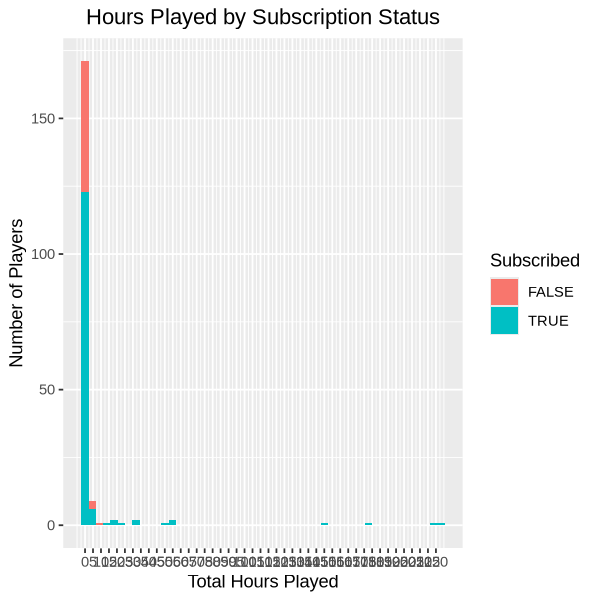

In [127]:
# Boxplot for played-hours
options(repr.plot.width = 5, repr.plot.height = 5)
played_hours_box <- players_merge |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram(bins = 50) +
    labs(x = "Total Hours Played", y = "Number of Players", title = "Hours Played by Subscription Status", fill = "Subscribed") +
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_x_continuous(breaks = seq(0, max(players_merge$played_hours, na.rm = TRUE), by = 5))
played_hours_box

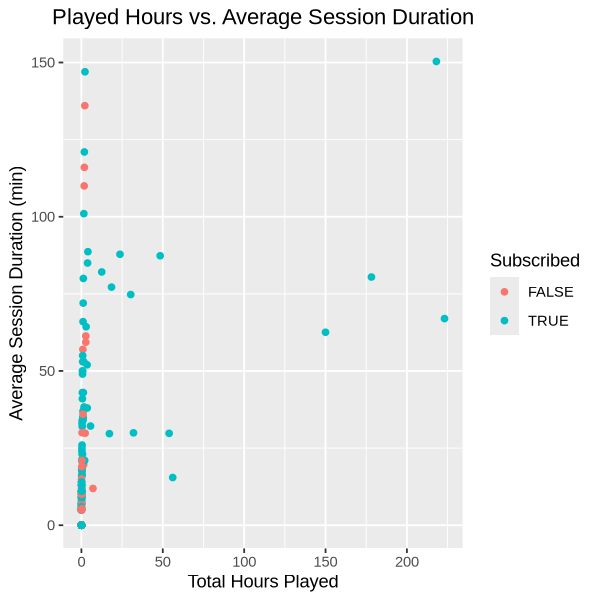

In [128]:
# Relationship between played_hours and avg_session duration by subscribe
options(repr.plot.width = 5, repr.plot.height = 5)
rel_hrs_avg <- players_merge |>
    ggplot(aes(x = played_hours, y = avg_session_duration, colour = subscribe)) +
    geom_point() +
    labs(x = "Total Hours Played", y = "Average Session Duration (min)", title = "Played Hours vs. Average Session Duration", colour = "Subscribed") +
    theme(plot.title = element_text(hjust = 0.5))
rel_hrs_avg

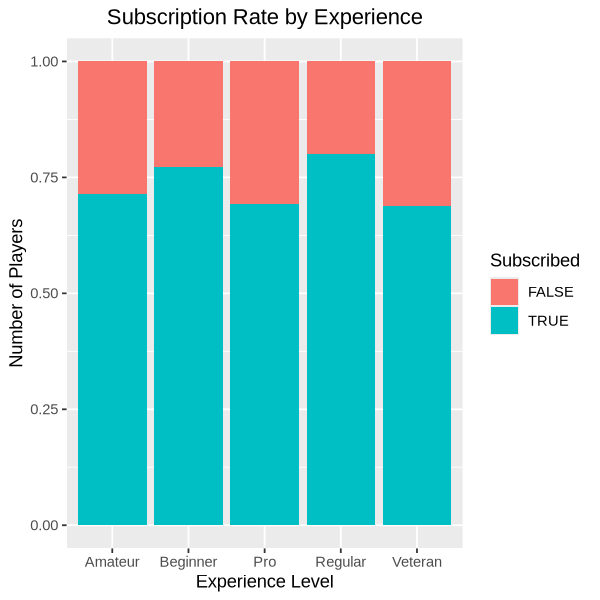

In [129]:
# Subscription by experience
options(repr.plot.width = 5, repr.plot.height = 5)
sub_exp <- players_merge |>
    ggplot(aes(x = experience, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Experience Level", y = "Number of Players", title = "Subscription Rate by Experience", fill = "Subscribed") +
    theme(plot.title = element_text(hjust = 0.5))
sub_exp

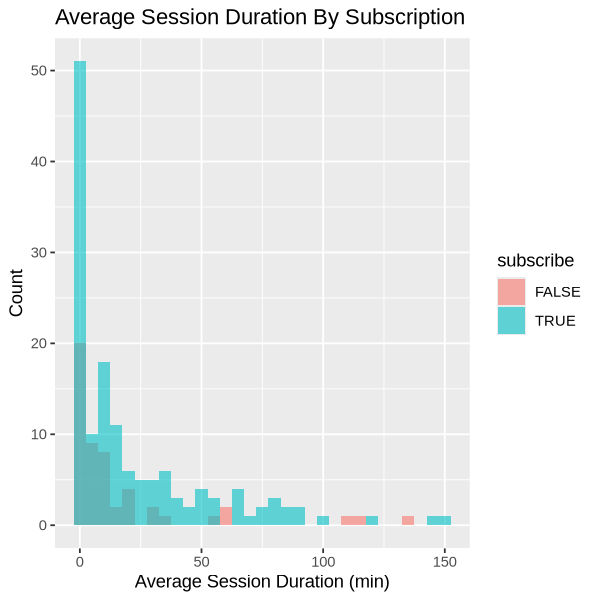

In [130]:
# Average session duration by Subscription
options(repr.plot.width = 5, repr.plot.height = 5)
avg_sesh_sub <- players_merge |>
    ggplot(aes(x = avg_session_duration, fill = subscribe)) + 
    geom_histogram(binwidth = 5, position = "identity", alpha = 0.6) +
    labs(x = "Average Session Duration (min)", y = "Count", title = "Average Session Duration By Subscription")
avg_sesh_sub

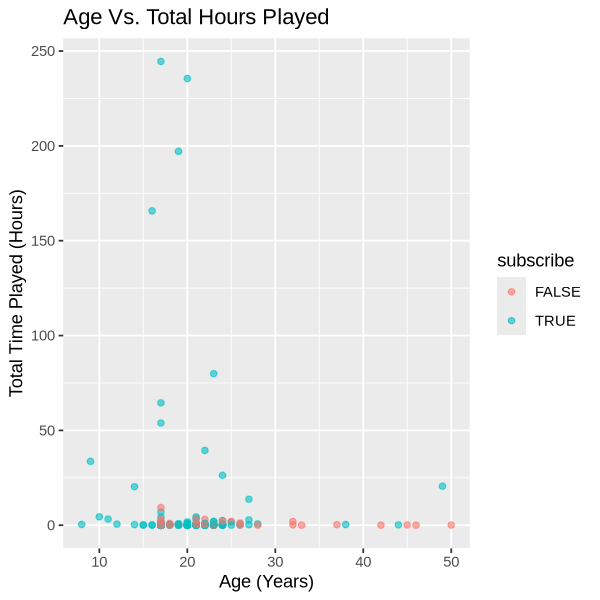

In [131]:
#Age vs. Total Hours Played
options(repr.plot.width = 5, repr.plot.height = 5)
age_total_hr <- players_merge |>
    ggplot(aes(x = Age, y = total_hours_played, colour = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (Years)", y = "Total Time Played (Hours)", title = "Age Vs. Total Hours Played", Colour = "Subscribe")
age_total_hr

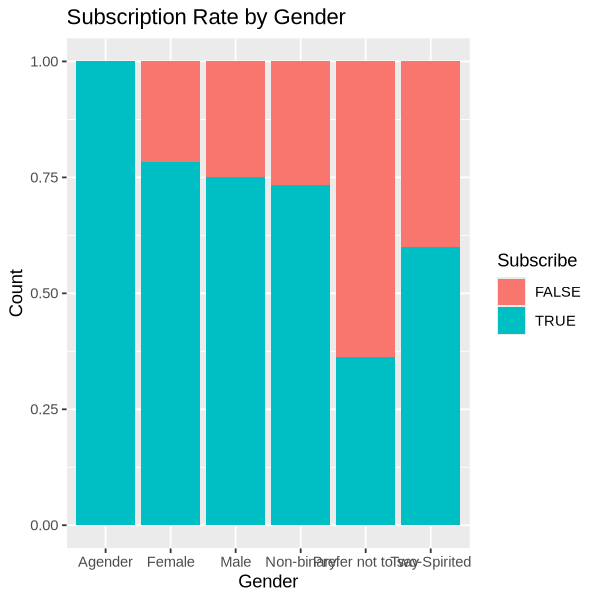

In [132]:
# Subscription by gender
options(repr.plot.width = 5, repr.plot.height = 5)
sub_gen <- players_merge |>
    ggplot(aes(x = gender, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Gender", y = "Count", title = "Subscription Rate by Gender", fill = "Subscribe")
sub_gen

## Modeling

### Data Setup

In [133]:
# Ensure results are reproducible 
set.seed(1234)

#split data
split <- initial_split(players_merge, strata = subscribe)
data_train <- training(split)
data_test <- testing(split)

### Model Recipe

In [134]:
# Recipe using numeric features
recipe_subscribe <- recipe(subscribe ~ played_hours + Age + total_sessions + avg_session_duration, data = data_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

### Model - Select best K

In [135]:
# KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#5-fold cross-validation
players_vfold <- vfold_cv(data_train, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

# Workflow
knn_results <- workflow() |>
    add_recipe(recipe_subscribe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

#best K
best_k <- knn_results |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k

[1] 19

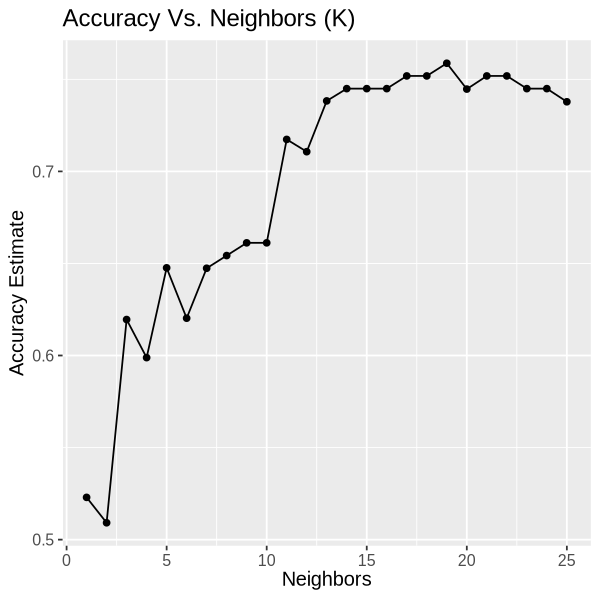

In [136]:
# Visualizing Accuracy Vs. K
accuracy_vs_k <- knn_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Vs. Neighbors (K)") +
  theme(text = element_text(size = 12))
accuracy_vs_k

### Model with Best K

In [137]:
# KNN model specification best K
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Workflow with best K
knn_workflow_best <- workflow() |>
    add_recipe(recipe_subscribe) |>
    add_model(knn_spec_best) |>
    fit(data_train)

# Model predictions
players_predictions <- predict(knn_workflow_best, data_test) |>
    bind_cols(data_test)

### Accuracy Metrics and Confusion Matrix

In [138]:
# Accuracy/Confusion
acc <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
confusion <- players_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
acc
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


          Truth
Prediction FALSE TRUE
     FALSE     1    2
     TRUE     12   34